## Imports and fetch

In [52]:
import os
import numpy as np
import urllib.request
import tarfile
import matplotlib.pyplot as plt

### Fetch

In [2]:
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [3]:
fetch_spam_data()

### Load all emails

##### getting all Mails

In [4]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [5]:
print(len(ham_filenames))
print(len(spam_filenames))

2500
500


We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [6]:
import email
import email.policy

def load_email(is_spam, filename, spam_path = SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [8]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [9]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


##### Checking stuctures of mails (Mine)

In [10]:
print(spam_emails[6].get_content_type())

text/plain


In [11]:
print(spam_emails[54].get_content())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD><TITLE>EM049</TITLE>
</HEAD>
<BODY bgColor="#FFFFFF" leftMargin="0" topMargin="0" MARGINHEIGHT="0" MARGINWIDTH="0">
<table width="550" border="0" cellspacing="0" cellpadding="0" align="center">
  <TBODY>
  <TR>
    <TD colSpan=2><A href="http://theadmanager.com/server/c.asp?ad_key=FWOATHSKUDMM&ext=1">
	<IMG src="http://admanmail.com/ads/adman/kmart/EM049_01.gif" alt="" border="0" height="59" width="550"></A></TD></TR>
  <TR>
    <TD><A href="http://theadmanager.com/server/c.asp?ad_key=FWOATHSKUDMM&ext=1">
	<IMG src="http://admanmail.com/ads/adman/kmart//EM049_02.gif" alt="" border="0" height="83" width="336"></A></TD>
    <TD><A href="http://theadmanager.com/server/c.asp?ad_key=FWOATHSKUDMM&ext=1">
	<IMG src="http://admanmail.com/ads/adman/kmart//EM049_03.gif" alt="" border=0 height=83 width=214></A></TD></TR>
  <TR>
    <TD><A href="http://theadmanager.com/server/c.asp?ad_key=FWOATHSKUDMM&ext=1">
	<IMG src="htt

In [12]:
with open("test.html","w") as f:
    f.writelines(spam_emails[54].get_content())

In [13]:
print(spam_emails[54].get_content_type())

text/html


##### Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [14]:
def get_email_structure(email):
    if isinstance(email,str):
        return email
    payload = email.get_payload()
    if isinstance(payload,list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email) for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [15]:
from collections import Counter
def structures_counter(emails):
    structures = Counter()
    for mail in emails:
        struct = get_email_structure(mail)
        structures[struct] += 1
    return structures

In [16]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [17]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.
<br><br>
Now let's take a look at the email headers:

In [18]:
for header, value in spam_emails[0].items():
    print(header,":",value,"\n","-------"*10,end="\n")

Return-Path : <12a1mailbot1@web.de> 
 ----------------------------------------------------------------------
Delivered-To : zzzz@localhost.spamassassin.taint.org 
 ----------------------------------------------------------------------
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT) 
 ----------------------------------------------------------------------
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST) 
 ----------------------------------------------------------------------
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100 
 ----------------------------------------------------------------------
From : 12a1mailbot1@web.de 
 ----------

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [19]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

##### Split data in Train and Test

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Get text from html

In [21]:
spam_emails[54].get_content_type()

'text/html'

In [22]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [23]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [24]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [25]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [26]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


## NLTK

In [27]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Error: stemming requires the NLTK module.


In [28]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator,TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
                
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [30]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christianity': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'one': 2, 'on': 2, 'been': 2, 'has': 2, 'half': 2, 'jesus': 2, 'some': 1, 'interesting': 1, 'quotes': 1, 'http': 1, 'www': 1, 'postfun': 1, 'com': 1, 'pfp': 1, 'worbois': 1, 'html': 1, 'thomas': 1, 'examined': 1, 'known': 1, 'superstitions': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'superstition': 1, 'redeeming': 1, 'feature': 1, 'they': 1, 'are': 1, 'alike': 1, 'founded': 1, 'fables': 1, 'mythology': 1, 'millions': 1, 'innocent': 1, 'men': 1, 'women': 1, 'children': 1, 'since': 1, 'introduction': 1, 'burnt': 1, 'tortured': 1, 'fined': 1, 'imprisoned': 1, 'what': 1, 'effect': 1, 'this': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fools': 1, 'other': 1, 'hypocrites': 1, 'support': 1, 'roguery': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1

In [31]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [32]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [33]:
X_few_vectors.toarray()

array([[  6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [112,  11,   9,   8,   3,   1,   0,   1,   3,   0,   1],
       [ 92,   0,   1,   2,   3,   4,   5,   3,   1,   4,   2]],
      dtype=int32)

In [34]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'http': 5,
 'NUMBER': 6,
 'com': 7,
 'all': 8,
 'yahoo': 9,
 'in': 10}

In [35]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [67]:
sum(y_train == 1)

405

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.983) total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ................................ score: (test=0.984) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ................................ score: (test=0.993) total time=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished


0.9862500000000001

<AxesSubplot:>

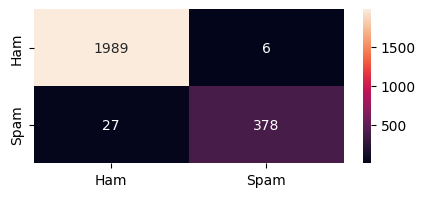

In [65]:
y_pred_log_clf = cross_val_predict(log_clf,X_train_transformed,y_train,cv=3)
plt.figure(figsize=(5,2))
sns.heatmap(confusion_matrix(y_train, y_pred_log_clf),
            annot=True,xticklabels=["Ham","Spam"],yticklabels=("Ham","Spam"),fmt='g')

### SVC

In [37]:
from sklearn.svm import SVC

In [39]:
svm_clf = SVC(kernel='rbf',random_state=42)
score = cross_val_score(svm_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.840) total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ................................ score: (test=0.843) total time=   1.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END ................................ score: (test=0.843) total time=   1.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s finished


0.8416666666666668

<AxesSubplot:>

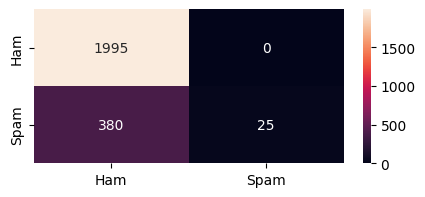

In [72]:
y_pred_svm_clf = cross_val_predict(svm_clf,X_train_transformed,y_train,cv=3)
plt.figure(figsize=(5,2))
sns.heatmap(confusion_matrix(y_train, y_pred_svm_clf),
            annot=True,xticklabels=["Ham","Spam"],yticklabels=("Ham","Spam"),fmt='g')

### Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
score = cross_val_score(nb_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.983) total time=   0.0s
[CV] END ................................ score: (test=0.990) total time=   0.0s
[CV] END ................................ score: (test=0.983) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


0.985

<AxesSubplot:>

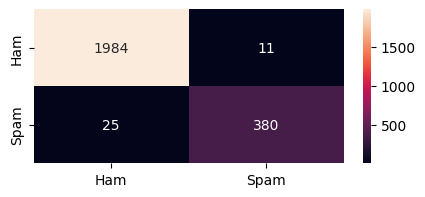

In [73]:
y_pred_nb_clf = cross_val_predict(nb_clf,X_train_transformed,y_train,cv=3)
plt.figure(figsize=(5,2))
sns.heatmap(confusion_matrix(y_train, y_pred_nb_clf),
            annot=True,xticklabels=["Ham","Spam"],yticklabels=("Ham","Spam"),fmt='g')

### Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
score = cross_val_score(dt_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.945) total time=   0.0s
[CV] END ................................ score: (test=0.950) total time=   0.0s
[CV] END ................................ score: (test=0.954) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


0.9495833333333333

<AxesSubplot:>

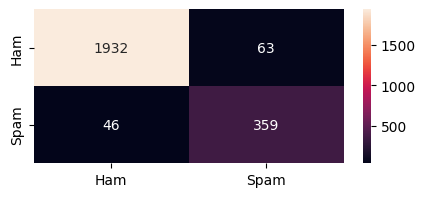

In [74]:
y_pred_dt_clf = cross_val_predict(dt_clf,X_train_transformed,y_train,cv=3)
plt.figure(figsize=(5,2))
sns.heatmap(confusion_matrix(y_train, y_pred_dt_clf),
            annot=True,xticklabels=["Ham","Spam"],yticklabels=("Ham","Spam"),fmt='g')

### KNN K = 1

In [69]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto')
score = cross_val_score(knn, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.934) total time=   0.0s
[CV] END ................................ score: (test=0.950) total time=   0.1s
[CV] END ................................ score: (test=0.916) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


0.9333333333333332

In [71]:
knn_3 = KNeighborsClassifier(n_neighbors=3)
score = cross_val_score(knn, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.934) total time=   0.0s
[CV] END ................................ score: (test=0.950) total time=   0.1s
[CV] END ................................ score: (test=0.916) total time=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


0.9333333333333332